<a href="https://colab.research.google.com/github/marreapato/Deep_Learning_Course/blob/main/Baseline_Com_Lags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tentando Aplicar o Shap

In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU# captum (biblioteca de interpretação pytorch)
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Download data for the stock (I'm using the Bovespa index as an example)
data = yf.download('^BVSP', '2007-01-01', '2023-10-17')
data = data[['Close']]





[*********************100%%**********************]  1 of 1 completed


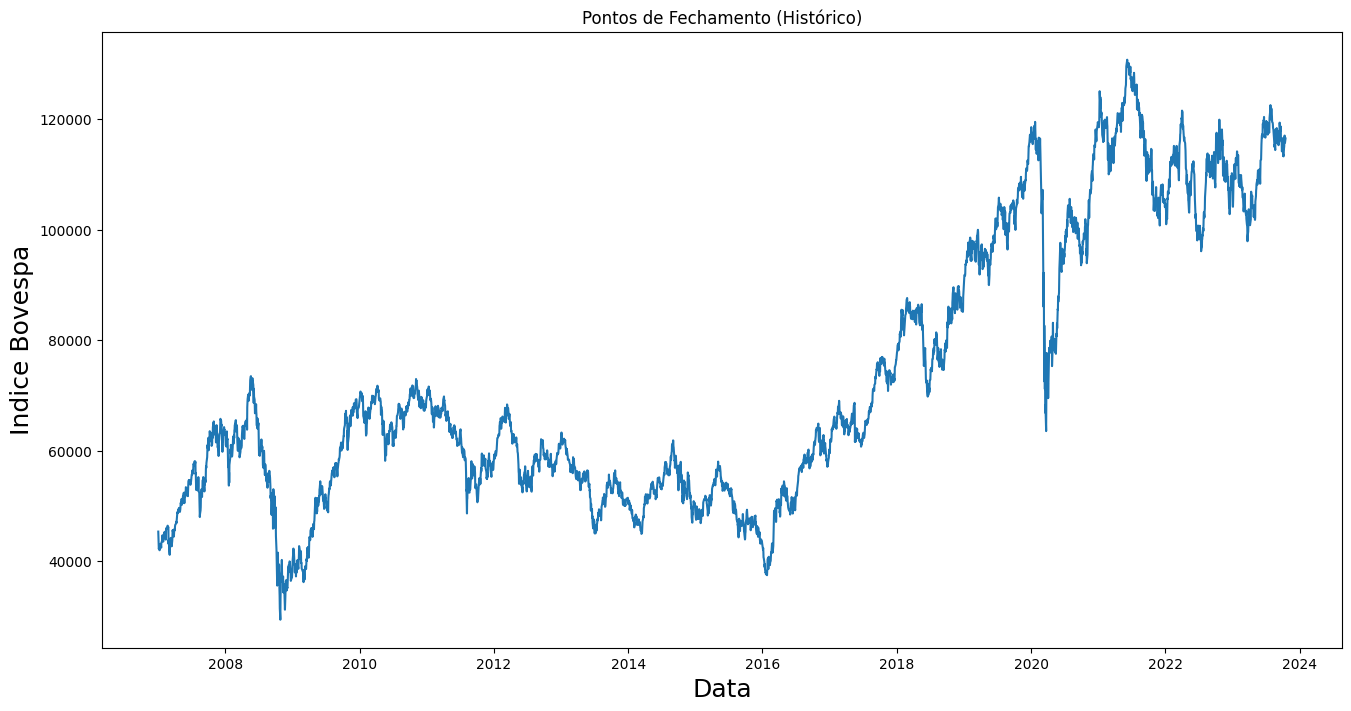

In [35]:
plt.figure(figsize=(16,8))
plt.title("Pontos de Fechamento (Histórico)")
plt.plot(data["Close"])
plt.xlabel("Data",fontsize=18)
plt.ylabel("Indice Bovespa",fontsize=18)
plt.show()

In [36]:
# Normalize the data
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong

def create_lagged_dataframe(data, lags, include_lag0=False):
    lagged_data = data.copy()

    if include_lag0:
        lagged_data['lag0'] = lagged_data['Close']

    for lag in range(1, lags + 1):
        lagged_data[f'lag{lag}'] = lagged_data['Close'].shift(lag)

    return lagged_data
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

<ipython-input-36-c28953203722>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))#use fit only in training that is wrong


In [37]:
from sklearn.model_selection import train_test_split

# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data, look_back, include_lag0)
lagged_data = lagged_data.dropna()  # Drop rows with NaN values

# Split the lagged data into features (X) and the target variable (Y)
X = lagged_data.drop(columns='Close').values
Y = lagged_data['Close'].values

# Split the data into training and testing sets
test_size = 0.2  # You can adjust the test size as needed
random_state = 42  # Set a random state for reproducibility

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print("TrainX shape:", trainX.shape)
print("TrainY shape:", trainY.shape)
print("TestX shape:", testX.shape)
print("TestY shape:", testY.shape)

TrainX shape: (3275, 60)
TrainY shape: (3275,)
TestX shape: (819, 60)
TestY shape: (819,)


In [39]:
trainX.shape

array([0.33644823, 0.84066666, 0.26580555, ..., 0.3883818 , 0.98682665,
       0.84982386])

In [40]:
trainX = np.array(trainX)
testX = np.array(testX)

In [41]:
# Reshape the input data for LSTM and GRU models
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the GRU model
def GRU_Model(output_window):
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the LSTM model
def LSTM_Model(output_window):
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(1, look_back)))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define the baseline model
def baseline_model(output_window):
    last_known_value = trainY[-1]
    return np.full((len(testY), output_window), last_known_value)

# Train and evaluate the models
output_window = 1
gru_model = GRU_Model(output_window)
lstm_model = LSTM_Model(output_window)

gru_model.fit(trainX, trainY, epochs=3, batch_size=64)
lstm_model.fit(trainX, trainY, epochs=3, batch_size=64)

gru_predictions = gru_model.predict(testX)
lstm_predictions = lstm_model.predict(testX)
baseline_predictions = baseline_model(output_window)

# Inverse transform the predictions
gru_predictions = scaler.inverse_transform(gru_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
baseline_predictions = scaler.inverse_transform(baseline_predictions)



Epoch 1/3
52/52 [==============================] - 2s 5ms/step - loss: 0.0175
Epoch 2/3
52/52 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 3/3
52/52 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 1/3
52/52 [==============================] - 2s 5ms/step - loss: 0.0204
Epoch 2/3
52/52 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 3/3
26/26 [==============================] - 0s 2ms/step


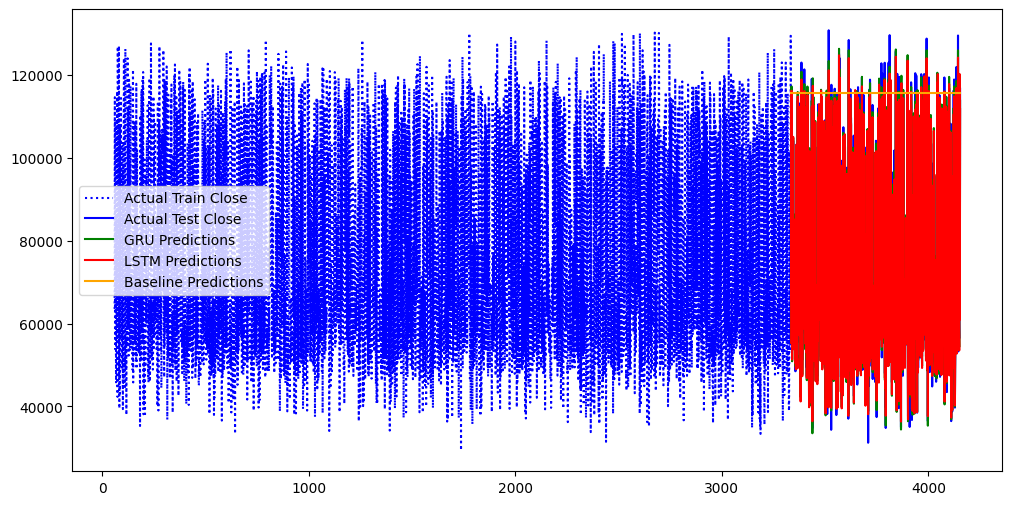

In [42]:
 #Inverse transform both train and test data
trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
testY = scaler.inverse_transform(testY.reshape(-1, 1))

# Create a time index for plotting
time_index_train = range(len(data) - len(testY) - len(trainY), len(data) - len(testY))
time_index_test = range(len(data) - len(testY), len(data))

# Plot all true values and the predictions with different colors
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, trainY, label='Actual Train Close', color='blue', linestyle='dotted')
plt.plot(time_index_test, testY, label='Actual Test Close', color='blue')
plt.plot(time_index_test, gru_predictions, label='GRU Predictions', color='green')
plt.plot(time_index_test, lstm_predictions, label='LSTM Predictions', color='red')
plt.plot(time_index_test, baseline_predictions, label='Baseline Predictions', color='orange')
plt.legend()
plt.show()

In [43]:
# Calculate the mean squared error for each model
gru_mse = mean_squared_error(testY, gru_predictions)
lstm_mse = mean_squared_error(testY, lstm_predictions)
baseline_mse = mean_squared_error(testY, baseline_predictions)

# Compare the models using Mean Squared Error
print("GRU Model RMSE: ", np.sqrt(gru_mse))
print("LSTM Model RMSE: ", np.sqrt(lstm_mse))
print("Baseline Model RMSE: ", np.sqrt(baseline_mse))


GRU Model RMSE:  3353.731384754243
LSTM Model RMSE:  3644.528921919222
Baseline Model RMSE:  49922.9737631537


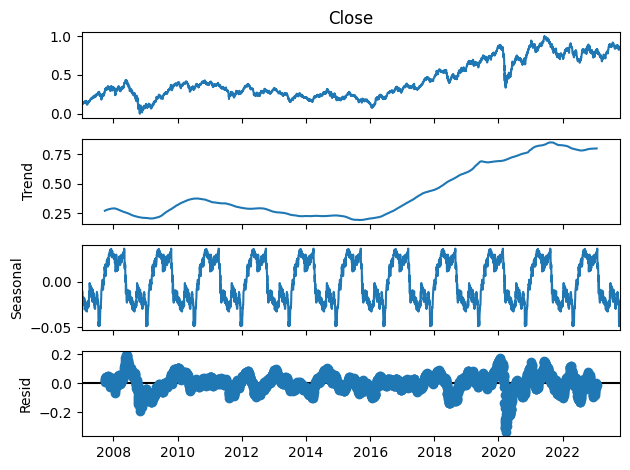

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Close'], model='additive',period=365)
result.plot()
plt.show()

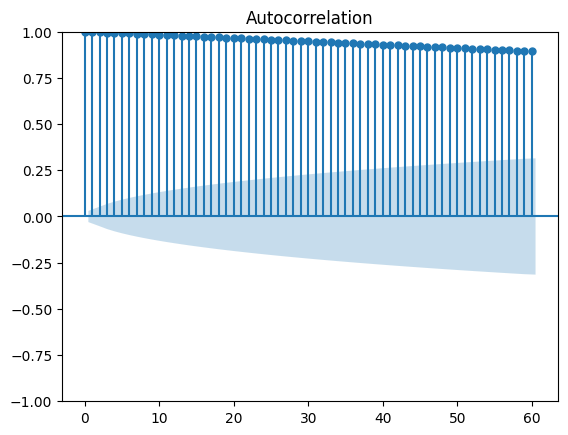

In [131]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Close'], lags=60)
plt.show()

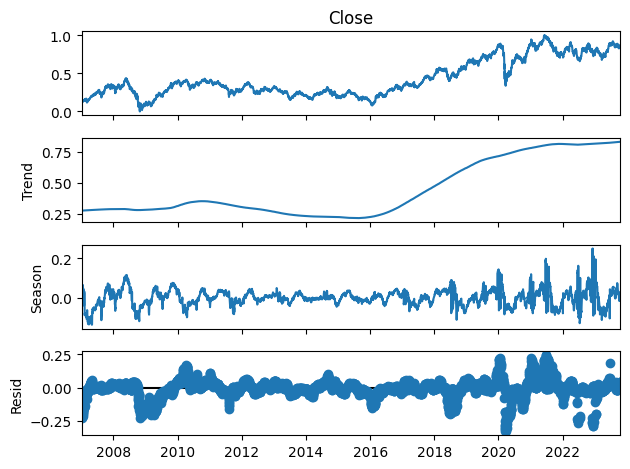

In [132]:
from statsmodels.tsa.seasonal import STL
stl = STL(data['Close'], period=365,robust=True)#looking for pattern that repeats annualy
res = stl.fit()
fig = res.plot()

In [46]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2007-01-01', '2023-09-22')
data2= data2[['Close']]
data2

last_60_days = data2[-look_back:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = X_test.reshape(-1,1,X_test.shape[1])
pred_price = lstm_model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 34ms/step
[[117102.21]]


In [47]:
# Download data for the stock (I'm using the Bovespa index as an example)
data2 = yf.download('^BVSP', '2023-09-23', '2023-09-26')
data2= data2[['Close']]
data2

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-09-25,115925.0


In [17]:
# Create lag features for the entire dataset
look_back = 60
include_lag0 = False  # You can set this to True if you want to include lag0

lagged_data = create_lagged_dataframe(data, look_back, include_lag0)
#lagged_data = lagged_data.dropna()  # Drop rows with NaN values
lagged_data

,Close,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-02,45383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-03,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-04,44020.0,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-05,42245.0,44020.0,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-08,42830.0,42245.0,44020.0,44445.0,45383.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0,116565.0,115731.0,114327.0,114193.0,...,119990.0,122560.0,122008.0,121342.0,120217.0,118083.0,117552.0,117841.0,118219.0,117711.0
2023-10-10,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0,116565.0,115731.0,114327.0,...,120187.0,119990.0,122560.0,122008.0,121342.0,120217.0,118083.0,117552.0,117841.0,118219.0
2023-10-11,117051.0,116737.0,115156.0,114170.0,113284.0,113607.0,113419.0,115057.0,116565.0,115731.0,...,121943.0,120187.0,119990.0,122560.0,122008.0,121342.0,120217.0,118083.0,117552.0,117841.0


In [19]:
# Save the final dataframe to a CSV file
lagged_data.to_csv('final_data.csv', index=False)  # Setting index=False to exclude the index column

# Print the first few rows of the final dataframe
print(lagged_data.head())

              Close     lag1     lag2     lag3     lag4  lag5  lag6  lag7  \
Date                                                                        
2007-01-02  45383.0      NaN      NaN      NaN      NaN   NaN   NaN   NaN   
2007-01-03  44445.0  45383.0      NaN      NaN      NaN   NaN   NaN   NaN   
2007-01-04  44020.0  44445.0  45383.0      NaN      NaN   NaN   NaN   NaN   
2007-01-05  42245.0  44020.0  44445.0  45383.0      NaN   NaN   NaN   NaN   
2007-01-08  42830.0  42245.0  44020.0  44445.0  45383.0   NaN   NaN   NaN   

            lag8  lag9  ...  lag51  lag52  lag53  lag54  lag55  lag56  lag57  \
Date                    ...                                                    
2007-01-02   NaN   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2007-01-03   NaN   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2007-01-04   NaN   NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2007-01-05   NaN   NaN  ...    NaN    NaN    NaN    NaN    N